In [1]:
import os
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2

color_map = {
    (0, 0, 0): 0,       # background
    (255, 0, 0): 1,     # crop
    (0, 0, 255): 2      # weed
}

def mask_to_class(mask_image, tolerance=10):
    mask = np.array(mask_image)
    class_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.uint8)

    for rgb, class_id in color_map.items():
        # Convert to np.array for broadcasting
        rgb_arr = np.array(rgb)

        # Calculate pixel-wise color distance
        diff = np.abs(mask - rgb_arr)
        matches = np.all(diff <= tolerance, axis=-1)

        class_mask[matches] = class_id

    return class_mask
class CropWeedDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = root_dir
        self.transform = transform
        txt_file = os.path.join(root_dir, f"{split}.txt")

        with open(txt_file, 'r') as f:
            self.names = [line.strip() for line in f.readlines()]

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
      name = self.names[idx]
      img_index = int(name.replace('.png', ''))  # clean for integer formatting
      img_path = os.path.join(self.root_dir, 'rgb', f"rgb_{img_index:05d}.png")
      mask_path = os.path.join(self.root_dir, 'annotations', name)  # no need to modify

      image = Image.open(img_path).convert('RGB')
      mask = Image.open(mask_path).convert('RGB')
      mask = mask_to_class(mask)

      if self.transform:
          augmented = self.transform(image=np.array(image), mask=mask)
          image = augmented['image']
          mask = augmented['mask']

      return image, mask.long()




/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.7'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataset_path = "/content/drive/MyDrive/SPRING 2024-2025/EE417/PROJECT/sugar_beets_2016/"

In [4]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.4, border_mode=0),
    A.RandomBrightnessContrast(brightness_limit=(-0.05, 0.4), contrast_limit=0.1, p=0.3),
    A.ColorJitter(brightness=0.1, contrast=0.05, saturation=0.05, hue=0.01, p=0.3),
    A.Resize(height=720, width=960),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(height=720, width=960),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2(),
])


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [5]:
import torch
from torch.utils.data import DataLoader, random_split
from torch.utils.data import random_split
from torch.utils.data import Subset


# Split indices reproducibly
generator = torch.Generator().manual_seed(42)

# Full dataset without transform initially
full_train = CropWeedDataset(root_dir=dataset_path, split='train', transform=None)

val_ratio = 0.2
val_size = int(len(full_train) * val_ratio)
train_size = len(full_train) - val_size

train_indices, val_indices = torch.utils.data.random_split(
    list(range(len(full_train))),
    [train_size, val_size],
    generator=generator
)

# Reapply transforms to subsets
train_dataset = Subset(CropWeedDataset(root_dir=dataset_path, split='train', transform=transform), train_indices)
val_dataset = Subset(CropWeedDataset(root_dir=dataset_path, split='train', transform=val_transform), val_indices)
test_dataset = CropWeedDataset(root_dir=dataset_path, split='test', transform=val_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

In [6]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import numpy as np
import random
import cv2

# defined class colors (background, crop, weed)
CLASS_COLORS = {
    0: (0, 0, 0),       # background - black
    1: (255, 0, 0),     # crop - red
    2: (0, 0, 255)      # weed - blue
}

def mask_to_rgb(mask):
    """Convert mask tensor to RGB image for visualization."""
    rgb = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for class_id, color in CLASS_COLORS.items():
        rgb[mask == class_id] = color
    return rgb

def visualize_training_samples(dataset, num_samples=5):
    """Visualize N random samples from a dataset (image, mask pair)."""
    indices = random.sample(range(len(dataset)), num_samples)
    for idx in indices:
        image, mask = dataset[idx]
        image_np = image.permute(1, 2, 0).cpu().numpy()  # C×H×W → H×W×C
        image_np = (image_np * 0.5 + 0.5) * 255           # unnormalize from mean=0.5, std=0.5
        image_np = image_np.astype(np.uint8)

        mask_np = mask.cpu().numpy()
        mask_rgb = mask_to_rgb(mask_np)

        blended = cv2.addWeighted(image_np, 0.6, mask_rgb, 0.4, 0)

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title("Image")
        plt.imshow(image_np)
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title("Ground Truth Mask")
        plt.imshow(mask_rgb)
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title("Overlay")
        plt.imshow(blended)
        plt.axis('off')

        plt.tight_layout()
        plt.show()

In [7]:
# Visualy check for agumentations
visualize_training_samples(train_dataset.dataset, num_samples=15)

Output hidden; open in https://colab.research.google.com to view.

In [8]:
from torchvision.models.segmentation import deeplabv3_resnet50
import torch.nn as nn
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = deeplabv3_resnet50(num_classes=3, weights=None).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Training Loop
for epoch in range(15):
    # ---------- Training ----------
    model.train()
    total_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)['out']
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # ---------- Validation ----------
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)['out']
            loss = criterion(outputs, masks)
            val_loss += loss.item()

    # ---------- Log Results ----------
    print(f"Epoch {epoch+1} | Train Loss: {total_loss:.4f} | Val Loss: {val_loss:.4f}")


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 237MB/s]


Epoch 1 | Train Loss: 38.7997 | Val Loss: 4.7599
Epoch 2 | Train Loss: 14.3214 | Val Loss: 2.7815
Epoch 3 | Train Loss: 9.8656 | Val Loss: 2.0013
Epoch 4 | Train Loss: 7.8753 | Val Loss: 2.1775
Epoch 5 | Train Loss: 6.3420 | Val Loss: 4.3493
Epoch 6 | Train Loss: 5.9690 | Val Loss: 1.5825
Epoch 7 | Train Loss: 5.3182 | Val Loss: 1.4746
Epoch 8 | Train Loss: 4.9423 | Val Loss: 1.4862
Epoch 9 | Train Loss: 4.9474 | Val Loss: 1.3557
Epoch 10 | Train Loss: 4.8601 | Val Loss: 1.4256
Epoch 11 | Train Loss: 4.3251 | Val Loss: 1.3645
Epoch 12 | Train Loss: 4.0104 | Val Loss: 1.5311
Epoch 13 | Train Loss: 3.8216 | Val Loss: 1.1244
Epoch 14 | Train Loss: 3.6954 | Val Loss: 1.1198
Epoch 15 | Train Loss: 3.6165 | Val Loss: 1.0717


In [9]:
import matplotlib.pyplot as plt

def visualize_predictions(model, dataloader, device, num_images=5):
    model.eval()
    images_shown = 0

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            outputs = model(images)['out']
            preds = torch.argmax(outputs, dim=1).cpu()
            images = images.cpu()
            masks = masks.cpu()

            for i in range(images.shape[0]):
                if images_shown >= num_images:
                    return

                fig, axs = plt.subplots(1, 3, figsize=(15, 5))

                # Denormalize image for visualization
                img = images[i].permute(1, 2, 0).numpy()
                img = (img * 0.5) + 0.5  # undo normalization
                img = np.clip(img, 0, 1)

                axs[0].imshow(img)
                axs[0].set_title("Input Image")
                axs[0].axis("off")

                axs[1].imshow(masks[i], cmap='tab10')
                axs[1].set_title("Ground Truth")
                axs[1].axis("off")

                axs[2].imshow(preds[i], cmap='tab10')
                axs[2].set_title("Prediction")
                axs[2].axis("off")

                plt.show()
                images_shown += 1


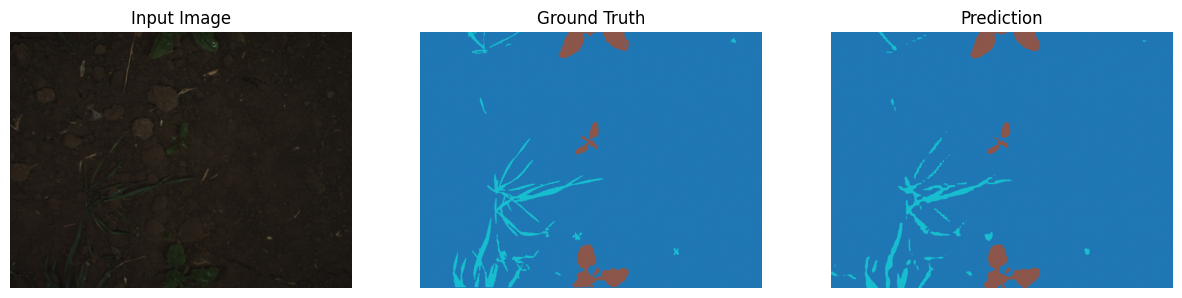

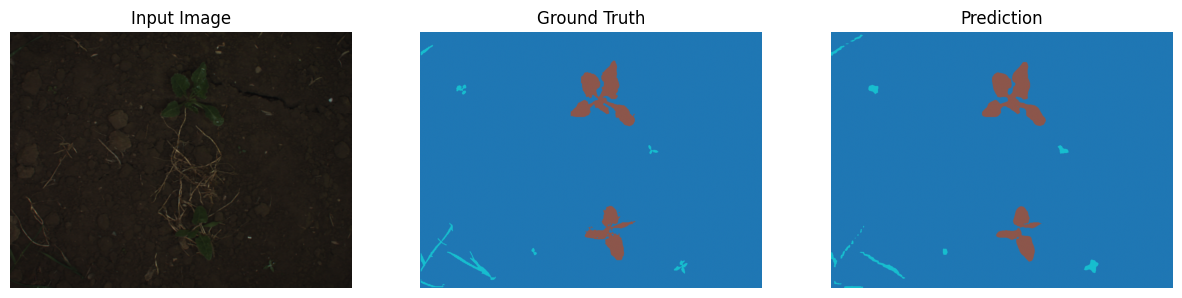

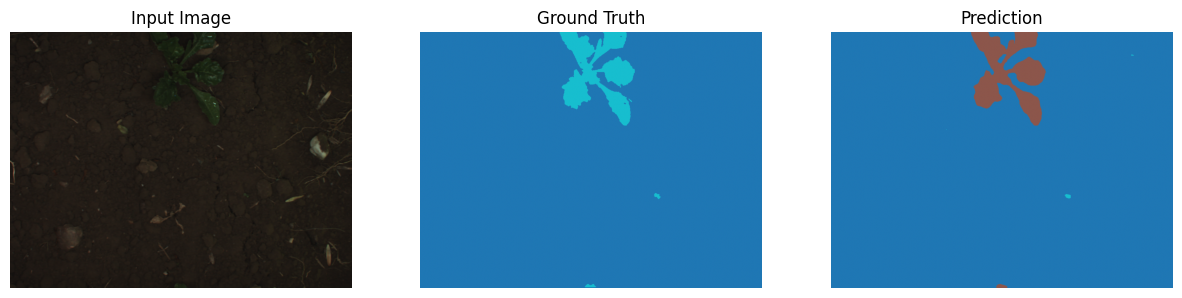

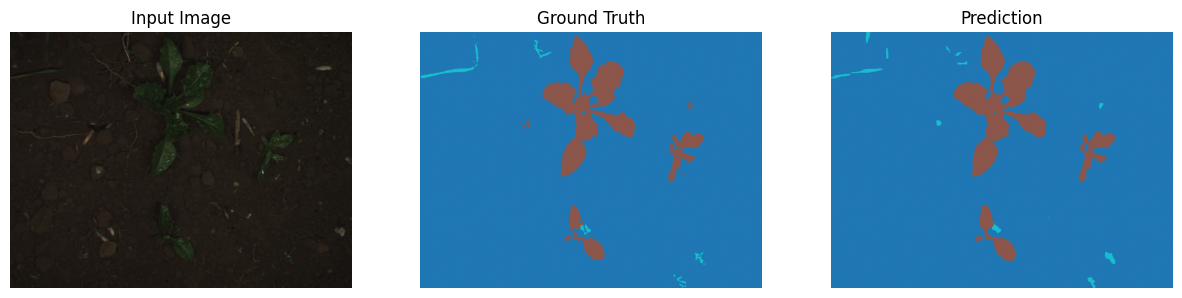

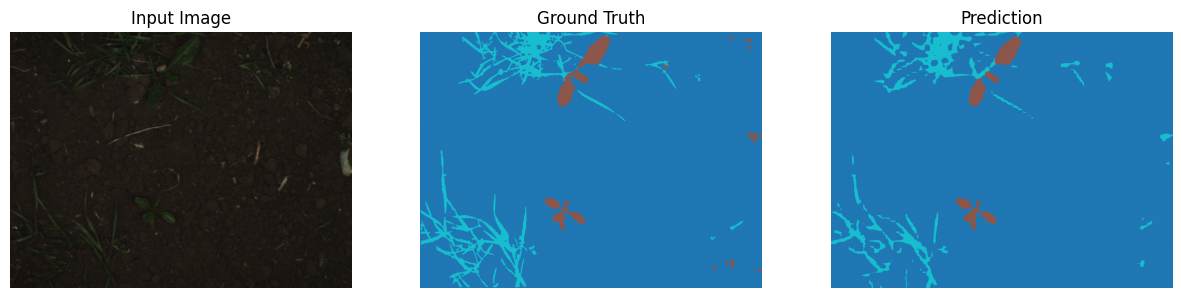

In [10]:
visualize_predictions(model, test_loader, device, num_images=5)

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np

# --- Evaluation Function ---
def evaluate(model, loader):
    model.eval()
    total_pixels, correct_pixels = 0, 0
    all_preds, all_labels = [], []
    mae_total = 0
    iou_per_class = []

    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)['out']
            preds = torch.argmax(outputs, dim=1)

            # Mask out background pixels (class 0)
            foreground_mask = masks != 0
            filtered_preds = preds[foreground_mask]
            filtered_masks = masks[foreground_mask]

            correct_pixels += (filtered_preds == filtered_masks).sum().item()
            total_pixels += foreground_mask.sum().item()

            all_preds.extend(filtered_preds.cpu().numpy().flatten())
            all_labels.extend(filtered_masks.cpu().numpy().flatten())

            mae_total += torch.abs(filtered_preds.float() - filtered_masks.float()).sum().item()

    # Metrics
    pixel_acc = correct_pixels / total_pixels
    f1 = f1_score(all_labels, all_preds, average='macro')
    mae = mae_total / total_pixels

    # Mean IoU
    cm = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2])
    ious = []
    for i in range(3):
        TP = cm[i, i]
        FP = cm[:, i].sum() - TP
        FN = cm[i, :].sum() - TP
        denom = TP + FP + FN
        iou = TP / denom if denom != 0 else 0
        ious.append(iou)
    miou = sum(ious) / len(ious)

    return pixel_acc, f1, miou, mae

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- Load Pretrained Model ---
weights = DeepLabV3_ResNet50_Weights.DEFAULT
model_pt = deeplabv3_resnet50(weights=weights).to(device)
model_pt.classifier[4] = nn.Conv2d(256, 3, kernel_size=1)  # Adjust for 3 classes
model_pt = model_pt.to(device)

# --- Optimizer, Loss, Scheduler ---
optimizer = torch.optim.Adam(model_pt.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
criterion = nn.CrossEntropyLoss()

# --- Training Loop ---
best_score = 0

for epoch in range(1, 16):
    model_pt.train()
    total_loss = 0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model_pt(images)['out']
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    scheduler.step()

    # Evaluate
    acc, f1, miou, mae = evaluate(model_pt, val_loader)
    combined_score = (f1 + miou) / 2

    # Save best model
    if combined_score > best_score:
        best_score = combined_score
        torch.save(model_pt.state_dict(), "best_model_combined.pth")

    # Logging
    print(f"Epoch {epoch:02d} | Train Loss: {total_loss:.4f}")
    print(f"→ Pixel Acc: {acc:.4f} | F1: {f1:.4f} | mIoU: {miou:.4f} | MAE: {mae:.4f} | Combined: {combined_score:.4f}")

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:00<00:00, 236MB/s]


Epoch 01 | Train Loss: 45.2997
→ Pixel Acc: 0.6473 | F1: 0.4684 | mIoU: 0.3842 | MAE: 0.5884 | Combined: 0.4263
Epoch 02 | Train Loss: 19.6621
→ Pixel Acc: 0.7899 | F1: 0.5627 | mIoU: 0.4946 | MAE: 0.3488 | Combined: 0.5287
Epoch 03 | Train Loss: 13.4312
→ Pixel Acc: 0.7833 | F1: 0.5571 | mIoU: 0.4872 | MAE: 0.3598 | Combined: 0.5222
Epoch 04 | Train Loss: 10.4878
→ Pixel Acc: 0.0017 | F1: 0.0018 | mIoU: 0.0009 | MAE: 1.3857 | Combined: 0.0014
Epoch 05 | Train Loss: 8.2414
→ Pixel Acc: 0.8241 | F1: 0.5746 | mIoU: 0.5111 | MAE: 0.2848 | Combined: 0.5429
Epoch 06 | Train Loss: 7.9614
→ Pixel Acc: 0.7268 | F1: 0.4988 | mIoU: 0.4184 | MAE: 0.4452 | Combined: 0.4586
Epoch 07 | Train Loss: 7.0211
→ Pixel Acc: 0.7820 | F1: 0.5418 | mIoU: 0.4677 | MAE: 0.3516 | Combined: 0.5047
Epoch 08 | Train Loss: 6.6427
→ Pixel Acc: 0.5249 | F1: 0.3666 | mIoU: 0.2815 | MAE: 0.7246 | Combined: 0.3240
Epoch 09 | Train Loss: 6.3055
→ Pixel Acc: 0.6660 | F1: 0.4652 | mIoU: 0.3836 | MAE: 0.5535 | Combined: 0.42

In [13]:
visualize_predictions(model_pt, test_loader, device, num_images=10)

Output hidden; open in https://colab.research.google.com to view.

In [14]:
acc, f1, miou, mae = evaluate(model, test_loader)

In [15]:
print(f"For Scratch model → Pixel Acc: {acc:.4f} | F1: {f1:.4f} | mIoU: {miou:.4f} | MAE: {mae:.4f}")

For Scratch model → Pixel Acc: 0.8568 | F1: 0.5881 | mIoU: 0.5332 | MAE: 0.2444


In [16]:
acc, f1, miou, mae = evaluate(model_pt, test_loader)

In [17]:
print(f"For PreTrained model → Pixel Acc: {acc:.4f} | F1: {f1:.4f} | mIoU: {miou:.4f} | MAE: {mae:.4f}")

For PreTrained model → Pixel Acc: 0.6378 | F1: 0.4553 | mIoU: 0.3682 | MAE: 0.5766


In [18]:
from torch.utils.data import random_split, DataLoader

def split_few_shot_deterministic(dataset, train_size=5, val_size=2, seed=42):
    """
    Split dataset into reproducible few-shot train, val, and test subsets using torch.Generator.
    """
    total_size = len(dataset)
    remaining = total_size - (train_size + val_size)
    lengths = [train_size, val_size, remaining]

    assert train_size + val_size <= total_size, "Not enough samples in the dataset for the requested split."

    generator = torch.Generator().manual_seed(seed)
    train_set, val_set, test_set = random_split(dataset, lengths, generator=generator)

    return train_set, val_set, test_set


In [19]:
import os
from PIL import Image
import numpy as np
from torch.utils.data import Dataset

"""
Convert RGB mask image to class indices:
- Red (255, 0, 0) -> 2 (weed)
- Green (0, 255, 0) -> 1 (crop)
- Everything else -> 0 (background)
"""
def mask_to_class_test(mask_image):
    mask = np.array(mask_image)
    class_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.uint8)

    # Weed (Red)
    weed_mask = np.all(mask == [255, 0, 0], axis=-1)
    class_mask[weed_mask] = 2

    # Crop (Green)
    crop_mask = np.all(mask == [0, 255, 0], axis=-1)
    class_mask[crop_mask] = 1

    return class_mask

class CropWeedTestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.image_mask_pairs = []

        # Check for Carrot format
        carrot_image_dir = os.path.join(root_dir, "images")
        carrot_mask_dir = os.path.join(root_dir, "annotations")

        if os.path.exists(carrot_image_dir) and os.path.exists(carrot_mask_dir):
            image_files = sorted([f for f in os.listdir(carrot_image_dir) if f.endswith("_image.png")])
            for fname in image_files:
                base = fname.replace("_image.png", "")
                image_path = os.path.join(carrot_image_dir, fname)
                mask_path = os.path.join(carrot_mask_dir, f"{base}_annotation.png")
                if os.path.exists(mask_path):
                    self.image_mask_pairs.append((image_path, mask_path))
                else:
                    print(f"⚠️ Missing annotation for {fname}")

        # Check for Sunflower format
        elif os.path.exists(os.path.join(root_dir, "rgb")) and os.path.exists(os.path.join(root_dir, "gt_color")):
            rgb_dir = os.path.join(root_dir, "rgb")
            gt_dir = os.path.join(root_dir, "gt_color")

            for fname in sorted(os.listdir(rgb_dir)):
                image_path = os.path.join(rgb_dir, fname)
                mask_path = os.path.join(gt_dir, fname)
                if os.path.exists(mask_path):
                    self.image_mask_pairs.append((image_path, mask_path))
                else:
                    print(f"⚠️ Missing mask for {fname}")

        else:
            raise ValueError("❌ Dataset format not recognized. Expected 'images/ + annotations/' or 'rgb/ + gt_color/'")

    def __len__(self):
        return len(self.image_mask_pairs)

    def __getitem__(self, idx):
        image_path, mask_path = self.image_mask_pairs[idx]

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("RGB")

        # Ensure same size
        if mask.size != image.size:
            mask = mask.resize(image.size, resample=Image.NEAREST)

        mask = mask_to_class_test(mask)  # returns a NumPy array of shape (H, W)

        if self.transform:
            augmented = self.transform(image=np.array(image), mask=mask)
            image = augmented['image']
            mask = augmented['mask']
            return image, mask.long()
        else:
            # Only return raw image and raw mask (PIL + np)
            return image, mask

In [20]:
import torch
import numpy as np
from torch.utils.data import Dataset

class TransformingSubset(Dataset):
    def __init__(self, subset, new_transform):
        self.subset = subset
        self.new_transform = new_transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        image, mask = self.subset[idx]

        # Force to numpy arrays
        if not isinstance(image, np.ndarray):
            image = np.array(image)

        if not isinstance(mask, np.ndarray):
            mask = np.array(mask)

        # Force shape of mask to (H, W) only
        if mask.ndim == 3:
            mask = mask[..., 0]  # take only one channel

        # Debug shape before transform
        # print(f"[Before transform] image: {image.shape}, mask: {mask.shape}")

        if self.new_transform:
            augmented = self.new_transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # Final fix: enforce mask is tensor
        if isinstance(mask, np.ndarray):
            mask = torch.from_numpy(mask)

        return image, mask.long()


In [21]:
carrot_dataset = CropWeedTestDataset(
    root_dir='/content/drive/MyDrive/SPRING 2024-2025/EE417/PROJECT/dataset-master',
    transform=None
)

# Reproducible few-shot split
carrot_train_set, carrot_val_set, carrot_test_set = split_few_shot_deterministic(
    carrot_dataset,
    train_size=8,
    val_size=2,
    seed=2024  # Change this to try different consistent splits
)

carrot_train_set = TransformingSubset(carrot_train_set, transform)
carrot_val_set = TransformingSubset(carrot_val_set, val_transform)
carrot_test_set = TransformingSubset(carrot_test_set, val_transform)

carrot_train_loader = DataLoader(carrot_train_set, batch_size=2, shuffle=True,drop_last=True )
carrot_val_loader = DataLoader(carrot_val_set, batch_size=2, shuffle=False)
carrot_test_loader = DataLoader(carrot_test_set, batch_size=2, shuffle=False)



In [22]:
print(f"Number of original training samples (non-augmented): {len(carrot_train_set)}")

Number of original training samples (non-augmented): 8


In [23]:
# Load sunflower dataset with base (val) transform
sunflower_dataset = CropWeedTestDataset(
    root_dir='/content/drive/MyDrive/SPRING 2024-2025/EE417/PROJECT/jesi_05_18',
    transform=None
)

# Split into reproducible few-shot subsets
sunflower_train_set, sunflower_val_set, sunflower_test_set = split_few_shot_deterministic(
    sunflower_dataset,
    train_size=8,
    val_size=2,
    seed=2024
)

# ✅ Apply training-time augmentations to the training subset
sunflower_train_set = TransformingSubset(sunflower_train_set, transform)
sunflower_val_set = TransformingSubset(sunflower_val_set, val_transform)
sunflower_test_set = TransformingSubset(sunflower_test_set, val_transform)

# Create DataLoaders
sunflower_train_loader = DataLoader(sunflower_train_set, batch_size=2, shuffle=True,drop_last=True )
sunflower_val_loader = DataLoader(sunflower_val_set, batch_size=2, shuffle=False)
sunflower_test_loader = DataLoader(sunflower_test_set, batch_size=2, shuffle=False)


In [24]:
print(f"Number of original training samples (non-augmented): {len(sunflower_train_set)}")

Number of original training samples (non-augmented): 8


In [25]:
for i in range(len(sunflower_dataset)):
    img_path, msk_path = sunflower_dataset.image_mask_pairs[i]
    img = Image.open(img_path)
    msk = Image.open(msk_path)
    if img.size != msk.size:
        print(f"Mismatch at index {i}: {img.size} vs {msk.size}")

In [26]:
acc, f1, miou, mae = evaluate(model, sunflower_test_loader)

In [27]:
print(f"For Scratch model zero-shot-sunflower → Pixel Acc: {acc:.4f} | F1: {f1:.4f} | mIoU: {miou:.4f} | MAE: {mae:.4f}")

For Scratch model zero-shot-sunflower → Pixel Acc: 0.3665 | F1: 0.2656 | mIoU: 0.1698 | MAE: 0.8509


In [33]:
acc, f1, miou, mae = evaluate(model_pt, sunflower_test_loader)

In [34]:
print(f"For Pretrained model zero-shot-sunflower → Pixel Acc: {acc:.4f} | F1: {f1:.4f} | mIoU: {miou:.4f} | MAE: {mae:.4f}")

For Pretrained model zero-shot-sunflower → Pixel Acc: 0.4142 | F1: 0.2051 | mIoU: 0.1428 | MAE: 0.6990


In [28]:
visualize_predictions(model, sunflower_test_loader, device, num_images=10)

Output hidden; open in https://colab.research.google.com to view.

In [29]:
acc, f1, miou, mae = evaluate(model, carrot_test_loader)

In [30]:
print(f"For Scratch model zero-shot-carrot → Pixel Acc: {acc:.4f} | F1: {f1:.4f} | mIoU: {miou:.4f} | MAE: {mae:.4f}")

For Scratch model zero-shot-carrot → Pixel Acc: 0.6351 | F1: 0.2656 | mIoU: 0.2208 | MAE: 0.5106


In [31]:
acc, f1, miou, mae = evaluate(model_pt, carrot_test_loader)

In [32]:
print(f"For Pretrained model zero-shot-carrot → Pixel Acc: {acc:.4f} | F1: {f1:.4f} | mIoU: {miou:.4f} | MAE: {mae:.4f}")

For Pretrained model zero-shot-carrot → Pixel Acc: 0.3280 | F1: 0.2385 | mIoU: 0.1499 | MAE: 0.9874


==============================================
# **Fine-tuning with a very small labeled subset of the target domain.**
==============================================


In [35]:
import copy

sunflower_model = copy.deepcopy(model)

In [36]:
import copy

carrot_model = copy.deepcopy(model)

=========
SUNFLOWER
=========

In [37]:
visualize_training_samples(sunflower_train_loader.dataset, num_samples=5)

Output hidden; open in https://colab.research.google.com to view.

In [38]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, sunflower_model.parameters()), lr=1e-5)
criterion = nn.CrossEntropyLoss()

for epoch in range(10):  # fewer epochs for fine-tuning
    sunflower_model.train()
    total_loss = 0
    for images, masks in sunflower_train_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = sunflower_model(images)['out']
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # ---------- Validation ----------
    sunflower_model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, masks in sunflower_val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = sunflower_model(images)['out']
            loss = criterion(outputs, masks)
            val_loss += loss.item()

    print(f"[Fine-Tune] Epoch {epoch+1} | Train Loss: {total_loss:.4f} | Val Loss: {val_loss:.4f}")


[Fine-Tune] Epoch 1 | Train Loss: 0.2225 | Val Loss: 0.0374
[Fine-Tune] Epoch 2 | Train Loss: 0.1966 | Val Loss: 0.0364
[Fine-Tune] Epoch 3 | Train Loss: 0.1811 | Val Loss: 0.0354
[Fine-Tune] Epoch 4 | Train Loss: 0.1759 | Val Loss: 0.0354
[Fine-Tune] Epoch 5 | Train Loss: 0.1412 | Val Loss: 0.0364
[Fine-Tune] Epoch 6 | Train Loss: 0.1408 | Val Loss: 0.0380
[Fine-Tune] Epoch 7 | Train Loss: 0.1425 | Val Loss: 0.0395
[Fine-Tune] Epoch 8 | Train Loss: 0.1391 | Val Loss: 0.0393
[Fine-Tune] Epoch 9 | Train Loss: 0.1501 | Val Loss: 0.0392
[Fine-Tune] Epoch 10 | Train Loss: 0.1332 | Val Loss: 0.0386


In [39]:
acc, f1, miou, mae = evaluate(sunflower_model, sunflower_test_loader)

In [40]:
print(f"For Scratch model few-trained-sunflower → Pixel Acc: {acc:.4f} | F1: {f1:.4f} | mIoU: {miou:.4f} | MAE: {mae:.4f}")

For Scratch model few-trained-sunflower → Pixel Acc: 0.8191 | F1: 0.5914 | mIoU: 0.5375 | MAE: 0.3300


In [41]:
visualize_predictions(sunflower_model, sunflower_test_loader, device, num_images=10)

Output hidden; open in https://colab.research.google.com to view.

=========
CARROT
=========

In [42]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, carrot_model.parameters()), lr=1e-5)
criterion = nn.CrossEntropyLoss()

for epoch in range(10):  # fewer epochs for fine-tuning
    carrot_model.train()
    total_loss = 0
    for images, masks in carrot_train_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = carrot_model(images)['out']
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # ---------- Validation ----------
    carrot_model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, masks in carrot_val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = carrot_model(images)['out']
            loss = criterion(outputs, masks)
            val_loss += loss.item()

    print(f"[Fine-Tune] Epoch {epoch+1} | Train Loss: {total_loss:.4f} | Val Loss: {val_loss:.4f}")


[Fine-Tune] Epoch 1 | Train Loss: 1.3456 | Val Loss: 0.2477
[Fine-Tune] Epoch 2 | Train Loss: 1.1536 | Val Loss: 0.2522
[Fine-Tune] Epoch 3 | Train Loss: 1.0431 | Val Loss: 0.2404
[Fine-Tune] Epoch 4 | Train Loss: 0.8774 | Val Loss: 0.2205
[Fine-Tune] Epoch 5 | Train Loss: 0.8297 | Val Loss: 0.1871
[Fine-Tune] Epoch 6 | Train Loss: 0.7115 | Val Loss: 0.1577
[Fine-Tune] Epoch 7 | Train Loss: 0.6629 | Val Loss: 0.1388
[Fine-Tune] Epoch 8 | Train Loss: 0.6246 | Val Loss: 0.1225
[Fine-Tune] Epoch 9 | Train Loss: 0.5320 | Val Loss: 0.1170
[Fine-Tune] Epoch 10 | Train Loss: 0.5198 | Val Loss: 0.1118


In [43]:
acc, f1, miou, mae = evaluate(carrot_model, carrot_test_loader)

In [44]:
print(f"For Scratch model few-trained-sunflower → Pixel Acc: {acc:.4f} | F1: {f1:.4f} | mIoU: {miou:.4f} | MAE: {mae:.4f}")

For Scratch model few-trained-sunflower → Pixel Acc: 0.6880 | F1: 0.4347 | mIoU: 0.3375 | MAE: 0.4389


In [45]:
visualize_predictions(carrot_model, carrot_test_loader, device, num_images=10)

Output hidden; open in https://colab.research.google.com to view.

TO SAVE MODEL


In [ ]:
save_path = "/content/drive/MyDrive/SPRING 2024-2025/EE417/PROJECT/Models/"
model_name = "deeplabv3_scratch.pth"
fullmodelpath = save_path + model_name

torch.save({
    'epoch': epoch + 1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': val_loss,
}, fullmodelpath)

print(f"Model saved to {fullmodelpath}")


Model saved to /content/drive/MyDrive/SPRING 2024-2025/EE417/PROJECT/Models/deeplabv3_scratch.pth


TO LOAD AND USE MODEL


In [ ]:
checkpoint = torch.load("deeplabv3_cropweed.pth", map_location=device)

model = deeplabv3_resnet50(num_classes=3)
model.classifier[4] = nn.Conv2d(256, 3, kernel_size=1)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()  # or .train() depending on use case

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

start_epoch = checkpoint['epoch']
print(f"Model restored from epoch {start_epoch}")
